In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
import os, sys, gc, warnings, random, datetime

/Users/shuozhang/anaconda/envs/py3k/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train=pd.read_csv('train_final4.csv')
test=pd.read_csv('test_final4.csv')

In [3]:
obj_cols = train.dtypes
obj_cols[obj_cols=='object']

DT                 object
addr1_card1        object
card2_and_count    object
dtype: object

In [4]:
train['card2_and_count']=pd.to_numeric(train['card2_and_count'],errors='coerce')
train['addr1_card1']=pd.to_numeric(train['addr1_card1'],errors='coerce')

In [5]:
test['card2_and_count']=pd.to_numeric(test['card2_and_count'],errors='coerce')
test['addr1_card1']=pd.to_numeric(test['addr1_card1'],errors='coerce')

In [6]:
split_groups = train['DT_M']

In [7]:
X= train.drop(['TransactionDT','TransactionID','uid','uid2','bank_type',
               'isFraud','DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month'], axis=1)
y = train['isFraud']

In [8]:
X.shape

(590540, 949)

In [9]:
X_test = test.drop(['TransactionDT','TransactionID','uid','uid2','bank_type',
                    'isFraud','DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month'], axis=1)

In [10]:
X_test.shape

(506691, 949)

In [11]:
del train, test
gc.collect()

7

In [12]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [13]:
SEED = 42
seed_everything(SEED)  
print(X.shape, X_test.shape)

(590540, 949) (506691, 949)


In [14]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'tree_learner':'serial',
          'max_depth': -1,
          'max_bin':255,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
         }

In [15]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [16]:
columns = X.columns
splits = folds.split(X, y, groups=split_groups)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.975576	valid_1's auc: 0.892714
[400]	training's auc: 0.991447	valid_1's auc: 0.902561
[600]	training's auc: 0.997661	valid_1's auc: 0.907207
[800]	training's auc: 0.999482	valid_1's auc: 0.910138
[1000]	training's auc: 0.999904	valid_1's auc: 0.912058
[1200]	training's auc: 0.999986	valid_1's auc: 0.91331
[1400]	training's auc: 0.999999	valid_1's auc: 0.914247
[1600]	training's auc: 1	valid_1's auc: 0.914724
[1800]	training's auc: 1	valid_1's auc: 0.915009
[2000]	training's auc: 1	valid_1's auc: 0.915389
[2200]	training's auc: 1	valid_1's auc: 0.915366
[2400]	training's auc: 1	valid_1's auc: 0.915432
Early stopping, best iteration is:
[1971]	training's auc: 1	valid_1's auc: 0.915318
Fold 1 | AUC: 0.9152869340193633
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.974864	valid_1's auc: 0.926312
[400]	training's auc: 0.991068	valid_1's auc: 0.937366
[600]	training'

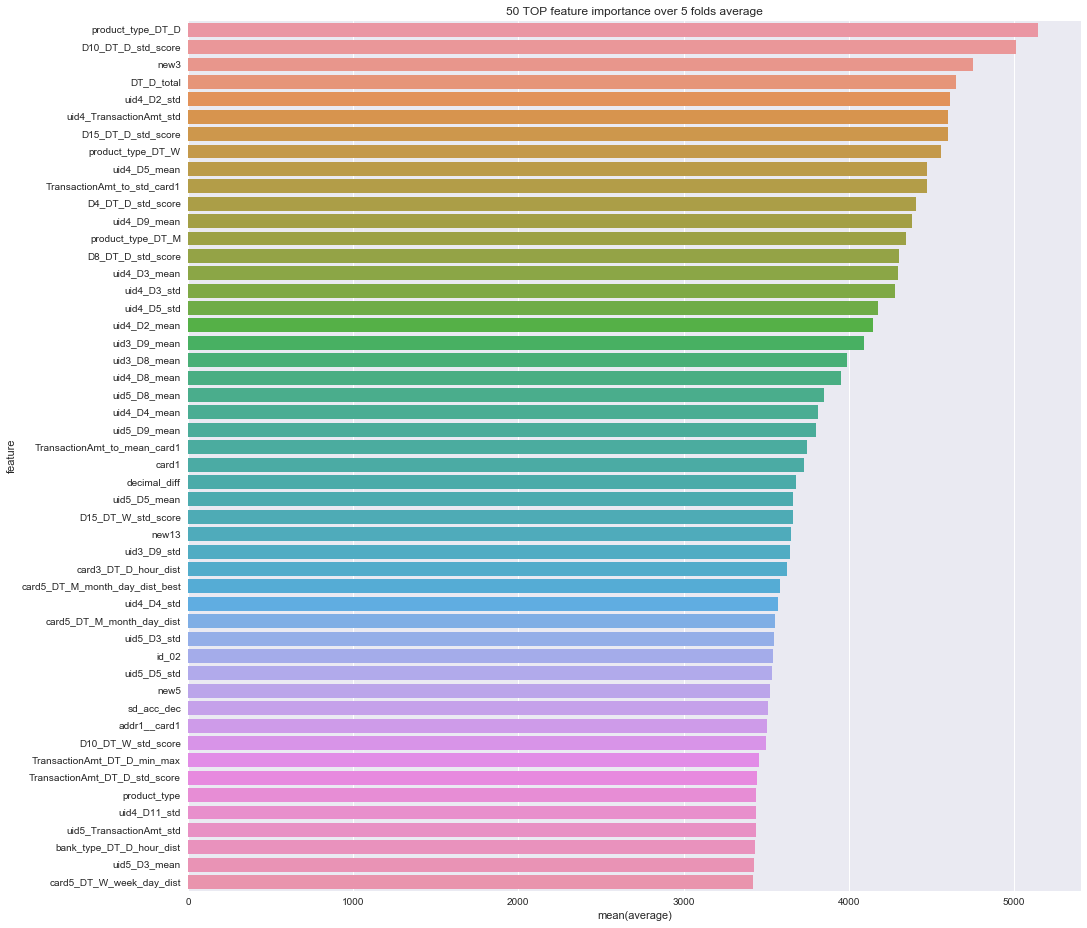

In [17]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

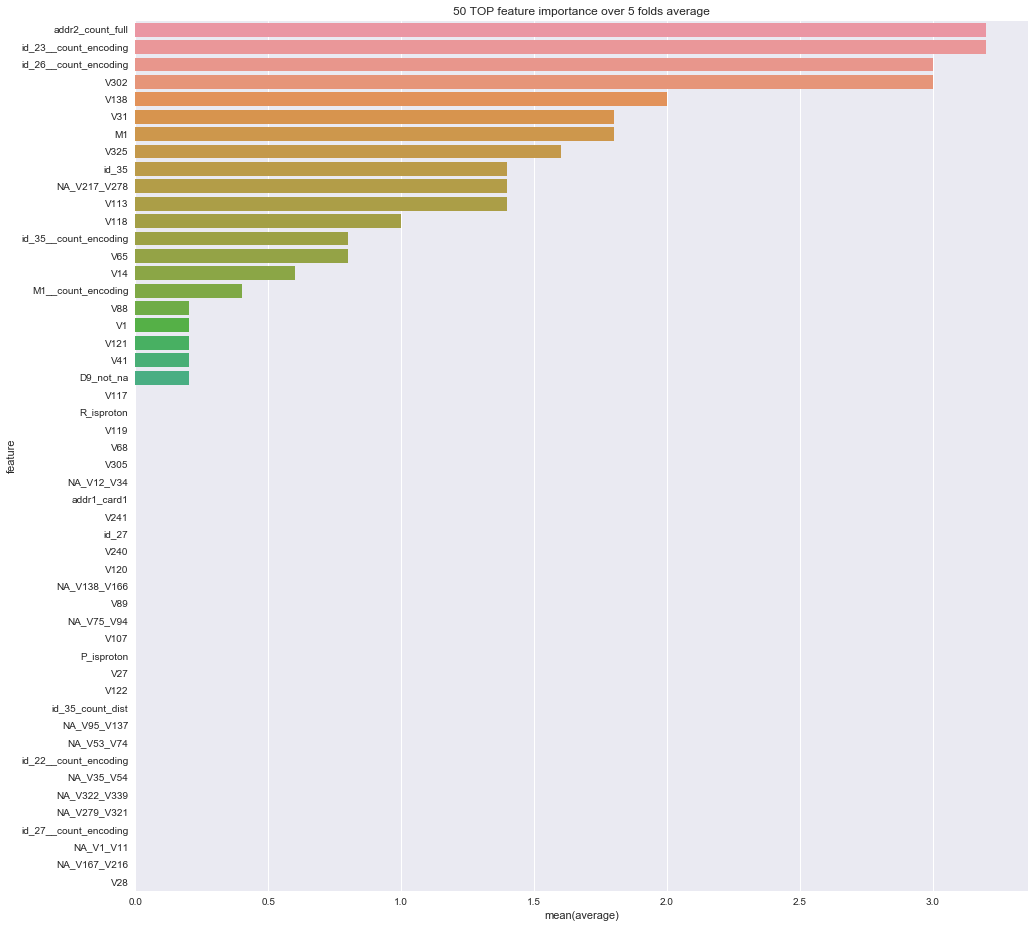

In [18]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).tail(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));


In [19]:
data=feature_importances.sort_values(by='average', ascending=False).tail(29) #根据结果设置
data

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
168,V117,0,0,0,0,0,0.0
833,R_isproton,0,0,0,0,0,0.0
170,V119,0,0,0,0,0,0.0
119,V68,0,0,0,0,0,0.0
356,V305,0,0,0,0,0,0.0
809,NA_V12_V34,0,0,0,0,0,0.0
849,addr1_card1,0,0,0,0,0,0.0
292,V241,0,0,0,0,0,0.0
757,id_27,0,0,0,0,0,0.0
291,V240,0,0,0,0,0,0.0


In [21]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv("lgb_final4_ano.csv", index=False)##0.9496

In [22]:
no_contribution_feature=data['feature']

In [23]:
no_contribution_feature

168                     V117
833               R_isproton
170                     V119
119                      V68
356                     V305
809               NA_V12_V34
849              addr1_card1
292                     V241
757                    id_27
291                     V240
171                     V120
810             NA_V138_V166
140                      V89
818               NA_V75_V94
158                     V107
826               P_isproton
78                       V27
173                     V122
918         id_35_count_dist
819              NA_V95_V137
817               NA_V53_V74
901    id_22__count_encoding
816               NA_V35_V54
815             NA_V322_V339
814             NA_V279_V321
906    id_27__count_encoding
812                NA_V1_V11
811             NA_V167_V216
79                       V28
Name: feature, dtype: object

In [24]:
X2=X.drop(no_contribution_feature, axis=1)

In [25]:
X2.shape

(590540, 920)

In [26]:
X_test2=X_test.drop(no_contribution_feature, axis=1)

In [27]:
X_test2.shape

(506691, 920)

In [28]:
del X, X_test
gc.collect()

42432

In [29]:
SEED = 42
seed_everything(SEED)  
print(X2.shape, X_test2.shape)

(590540, 920) (506691, 920)


In [30]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [31]:
columns = X2.columns
splits = folds.split(X2, y, groups=split_groups)
y_preds = np.zeros(X_test2.shape[0])
y_oof = np.zeros(X2.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X2[columns].iloc[train_index], X2[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test2) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.975466	valid_1's auc: 0.892419
[400]	training's auc: 0.991466	valid_1's auc: 0.901799
[600]	training's auc: 0.997636	valid_1's auc: 0.906507
[800]	training's auc: 0.999478	valid_1's auc: 0.909963
[1000]	training's auc: 0.999904	valid_1's auc: 0.911866
[1200]	training's auc: 0.999986	valid_1's auc: 0.912794
[1400]	training's auc: 0.999998	valid_1's auc: 0.913976
[1600]	training's auc: 1	valid_1's auc: 0.914736
[1800]	training's auc: 1	valid_1's auc: 0.915228
[2000]	training's auc: 1	valid_1's auc: 0.915526
[2200]	training's auc: 1	valid_1's auc: 0.915818
[2400]	training's auc: 1	valid_1's auc: 0.915962
Early stopping, best iteration is:
[1979]	training's auc: 1	valid_1's auc: 0.91553
Fold 1 | AUC: 0.9154944170408522
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.974642	valid_1's auc: 0.926931
[400]	training's auc: 0.99104	valid_1's auc: 0.937666
[600]	training's

In [35]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv("lgb_final4_ano2.csv", index=False) #0.9497

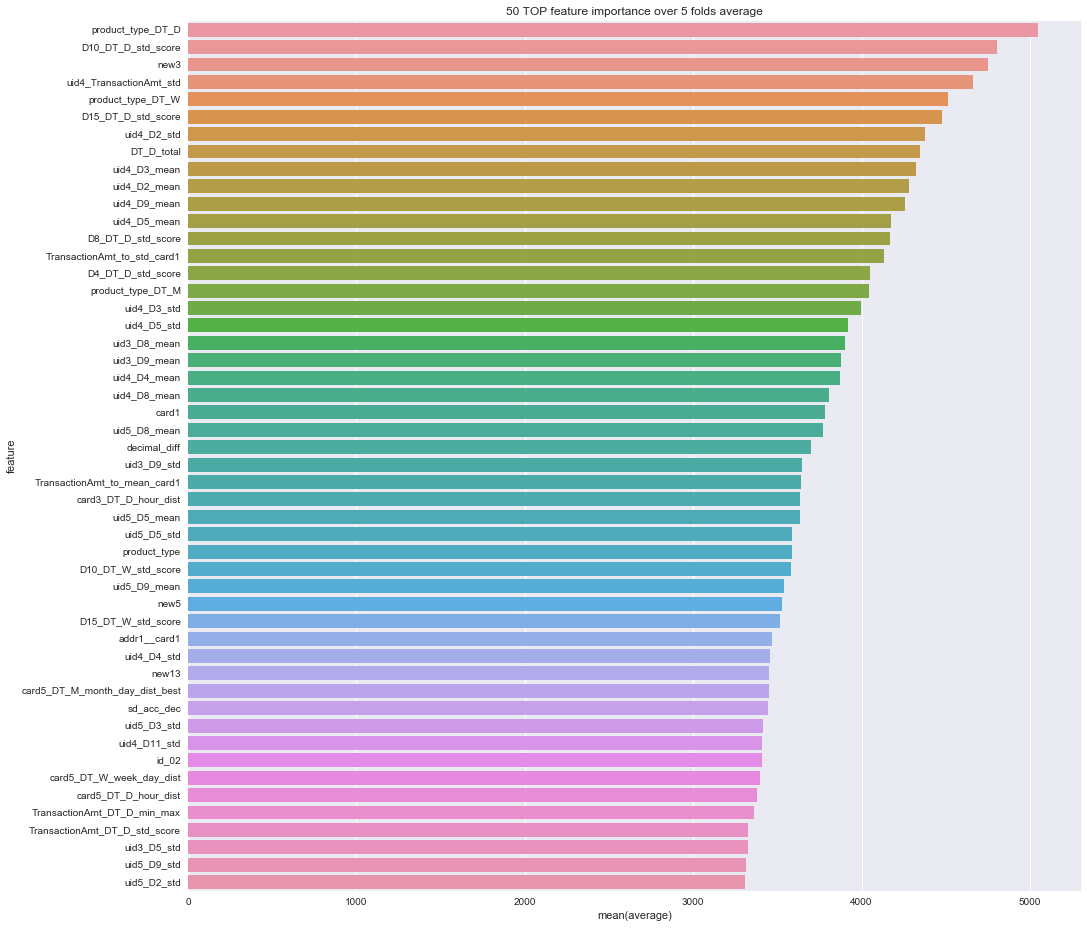

In [32]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

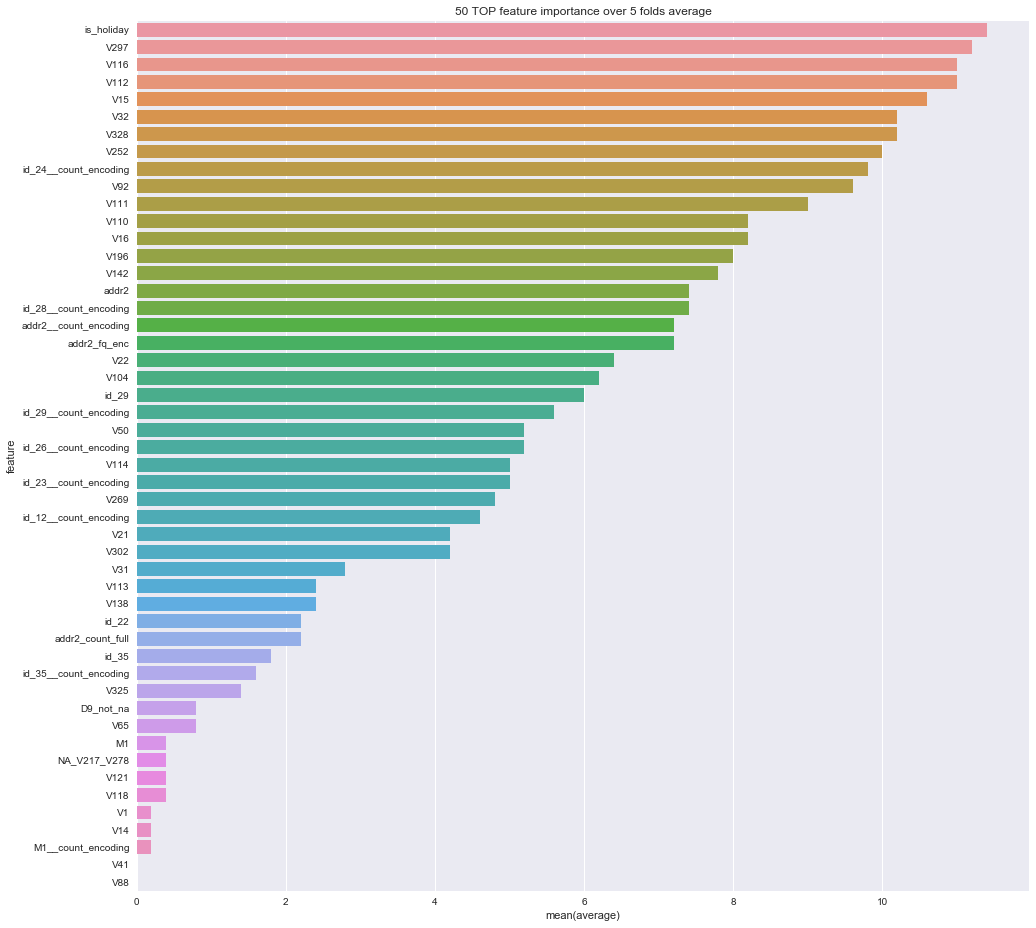

In [33]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).tail(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));